# Tiktok

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import re
from difflib import SequenceMatcher

In [22]:
tt_june = (
    pd.read_csv('DATA/tiktokjune2022.csv')
    .assign(Month='June')
    .rename(columns={
        "Tiktoker": "username",
        "influencer name":"name",
        "Subscribers count": "subs",
        "Views avg.": "views",
        "Likes avg": "likes",
        "Comments avg.": "comments",
        "Shares avg": "shares",
        "Month": "month"
    })
)
tt_june.head(1)

,username,name,subs,views,likes,comments,shares,month
0,___nicoichi___,NICO【平成フラミンゴ】,1.3M,1.9M,225.3K,1.7K,1.1K,June


In [23]:
tt_sep = (
    pd.read_csv('DATA/Tiktoksep2022.csv')
    .assign(Month='September')
    .rename(columns={
        "Tiktoker name": "username",
        "Tiktok name":"name",
        "Subscribers": "subs",
        "Views avg.": "views",
        "Likes avg.": "likes",
        "Comments avg.": "comments",
        "Shares avg.": "shares",
        "Month": "month"
    })
    .drop("S.no", axis=1)
)
tt_sep.head(1)

,username,name,subs,views,likes,comments,shares,month
0,jypestraykids,Stray Kids,13.8M,6.4M,2.3M,50.2K,34.2K,September


In [24]:
tt_nov = (
    pd.read_csv('DATA/tiktoknov2022.csv')
    .assign(Month='November')
    .rename(columns={
        "Tiktoker name": "username",
        "Tiktok name":"name",
        "\nFollowers": "subs",
        "Views (Avg.)": "views",
        "Likes (Avg.)": "likes",
        "Comments (Avg.)": "comments",
        "Shares (Avg.)": "shares",
        "Month": "month"
    })
    .drop("row-cell", axis=1)
    .drop(0)
)
tt_nov.head(1)

,username,name,subs,views,likes,comments,shares,month
1,yossikramer,Yossi,145.6K,26.8M,2.2M,30.1K,71.2K,November


In [25]:
tt_dec = (
    pd.read_csv('DATA/TIKTOKDEC2022.csv')
    .assign(Month='December')
    .rename(columns={
        "Tiktoker name": "username",
        "Tiktok name":"name",
        "followers": "subs",
        "views(avg)": "views",
        "likes(avg.)": "likes",
        "comments(avg.)": "comments",
        "shares(avg.)": "shares",
        "Month": "month"
    })
    .drop("Rank", axis=1)
)
tt_dec.head(1)

,username,name,subs,views,likes,comments,shares,month
0,mrbeast,MrBeast,60.3M,29.2M,3.5M,30.8K,7.2K,December


In [26]:
def cientific_int(column: pd.Series) -> pd.Series:
    return (
        column
        .fillna('0')
        .replace({'K': '*1e3', 'M': '*1e6', 'G':'*1e9'}, regex=True)
        .map(pd.eval)
        .astype(int)
        .replace(0, np.nan)
    )


numeric_text_cols = ['subs', 'views', 'likes', 'comments', 'shares']

tt_june.loc[:, numeric_text_cols] = tt_june[numeric_text_cols].apply(cientific_int)
tt_sep.loc[:, numeric_text_cols] = tt_sep[numeric_text_cols].apply(cientific_int)
tt_nov.loc[:, numeric_text_cols] = tt_nov[numeric_text_cols].apply(cientific_int)
tt_dec.loc[:, numeric_text_cols] = tt_dec[numeric_text_cols].apply(cientific_int)

In [27]:
tt_months = (
    pd.concat([tt_june, tt_sep, tt_nov, tt_dec], ignore_index=True)
    .drop_duplicates()
)

tt_months.head(3)

,username,name,subs,views,likes,comments,shares,month
0,___nicoichi___,NICO【平成フラミンゴ】,1300000,1900000,225300,1700.0,1100,June
1,_.anime.edits_0,video,97000,1700000,75600,1500.0,8700,June
2,_.respect.boss._,Respect compilation 🤝🥶,1500000,4400000,241900,249.0,797,June


# Análisis

## 1. Tenemos 3055 cuentas únicas en nuestros registros de tiktok


In [28]:
tt_months.username.drop_duplicates().size

2582

## 2. Medias de followers, views, likes, comments y shares de cada cuenta

In [29]:
tt_means = (
    tt_months
    .groupby('username')
     # aggregate functiosn skips nan by deffault
    .aggregate({
        'subs': 'mean',
        'views': 'mean',
        'likes': 'mean',
        'comments': 'mean',
        'shares': 'mean'
    })    
    .reset_index()
    .sort_values('subs', ascending=False)
)

In [30]:
tt_means

,username,subs,views,likes,comments,shares
1294,khaby.lame,149375000.0,17050000.0,2050000.0,16500.0,7625.0
463,charlidamelio,146400000.0,11999999.75,1047800.0,16175.0,4900.0
299,bellapoarch,91400000.0,6733333.333333,693800.0,6400.0,1266.666667
80,addisonre,88525000.0,10400000.0,609750.0,4200.0,8500.0
2495,willsmith,73000000.0,4700000.0,514600.0,2200.0,2000.0
...,...,...,...,...,...,...
2194,soapinmymouthoncemore,5100.0,943300.0,189600.0,1900.0,3100.0
1222,juliaaliceaa,3700.0,2200000.0,550300.0,3100.0,14300.0
128,alexbatistao,3200.0,951700.0,46600.0,1700.0,19400.0
1408,leonardzbant,3000.0,1700000.0,131200.0,486.0,9600.0


## 3. Métricas de valor

In [31]:
tt_means['views_ratio'] = tt_means.views / tt_means.subs
tt_means['likes_ratio'] = tt_means.likes / tt_means.subs
tt_means['comments_ratio'] = tt_means.comments / tt_means.subs
tt_means['share_ratio'] = tt_means.shares / tt_means.subs

In [32]:
tt_means

,username,subs,views,likes,comments,shares,views_ratio,likes_ratio,comments_ratio,share_ratio
1294,khaby.lame,149375000.0,17050000.0,2050000.0,16500.0,7625.0,0.114142,0.013724,0.00011,0.000051
463,charlidamelio,146400000.0,11999999.75,1047800.0,16175.0,4900.0,0.081967,0.007157,0.00011,0.000033
299,bellapoarch,91400000.0,6733333.333333,693800.0,6400.0,1266.666667,0.073669,0.007591,0.00007,0.000014
80,addisonre,88525000.0,10400000.0,609750.0,4200.0,8500.0,0.117481,0.006888,0.000047,0.000096
2495,willsmith,73000000.0,4700000.0,514600.0,2200.0,2000.0,0.064384,0.007049,0.00003,0.000027
...,...,...,...,...,...,...,...,...,...,...
2194,soapinmymouthoncemore,5100.0,943300.0,189600.0,1900.0,3100.0,184.960784,37.176471,0.372549,0.607843
1222,juliaaliceaa,3700.0,2200000.0,550300.0,3100.0,14300.0,594.594595,148.72973,0.837838,3.864865
128,alexbatistao,3200.0,951700.0,46600.0,1700.0,19400.0,297.40625,14.5625,0.53125,6.0625
1408,leonardzbant,3000.0,1700000.0,131200.0,486.0,9600.0,566.666667,43.733333,0.162,3.2


## 4. Gráficas del numero de cuentas que inicien por cada letra del alfabeto y agrupar en una categoría todos los que no comiencen con una letra del alfabeto

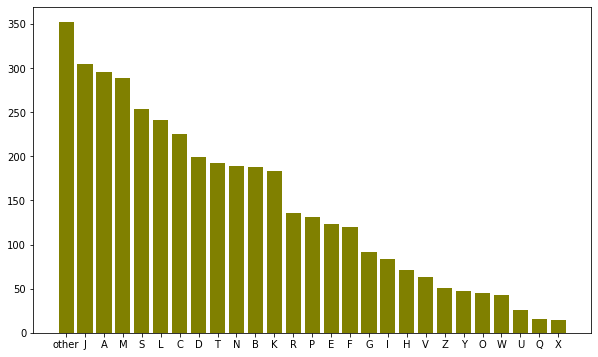

In [33]:
def get_inicial(name: str) -> str:
    name = str(name)
    first_is_letter = re.search(r'^[a-zA-Z]', name)
    if first_is_letter:
        return name[0].upper()
    else:
        return 'other'


initials = (
    tt_months.name
    .map(get_inicial)
    .value_counts()
    .reset_index(name='frequency')
    .rename(columns={
        'index': 'letter',
        'name': 'letter'
    })
)
plt.figure(figsize=(10, 6)) 
plt.bar(initials.letter, initials.frequency, color = 'olive')
plt.show()

## 5. ¿Cual es la cuenta de tiktok con mas caracteres en su nombre?

In [34]:
name_len = (
    tt_months[['name', 'username']]
    .assign(len_name = tt_months.name.map(lambda x: len(str(x))))
    .assign(len_username = tt_months.username.map(lambda x: len(str(x))))
)
tds1 = name_len.loc[name_len.len_name.idxmax()]
tds2 = name_len.loc[name_len.len_username.idxmax()]

In [35]:
tds2

name            Squatch and Sons Customs
username        squatch.and.sons_customs
len_name                              24
len_username                          24
Name: 1167, dtype: object

In [36]:
tds1

name            Prite Netijen Netirattanapaiboon
username                           spriteder_spd
len_name                                      32
len_username                                  13
Name: 1501, dtype: object

## 6. Cuántas cuentas de tiktok tienen el nombre del aguno de estos animales: perro, gato, leon tigre?

In [37]:
(tt_months.username.str.contains(r'^(perro|gato|leon|tigre)$') | tt_months.username.str.contains(r'^(perro|gato|leon|tigre)$')).sum()

/tmp/ipykernel_142691/3064001155.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  (tt_months.username.str.contains(r'^(perro|gato|leon|tigre)$') | tt_months.username.str.contains(r'^(perro|gato|leon|tigre)$')).sum()


0

## 7. Defina una metrica que identifique las 10 cuentas más importantes de tiktok

In [38]:
tt_means = (
    tt_means
    .assign(
        gen_engagement = ((tt_means.comments / tt_means.views) + (tt_means.likes / tt_means.views)) * (tt_means.subs / max(tt_means.subs))
    )
    .sort_values(['gen_engagement'], ascending=False)
)
tt_means[['username', 'gen_engagement']].head(10)

,username,gen_engagement
1294,khaby.lame,0.121202
463,charlidamelio,0.086899
299,bellapoarch,0.06363
1306,kimberly.loaiza,0.059311
658,domelipa,0.05813
1248,kallmekris,0.054957
2495,willsmith,0.053737
2353,therock,0.050176
1351,kyliejenner,0.047387
2128,selenagomez,0.046642


## 8. Grafique una serie de tiempo de las cuentas que tengan al menos 3 datos de meses distintos de los promedios obtenidos en el inciso II

In [39]:
tt_months.head(0)

,username,name,subs,views,likes,comments,shares,month
